## Multi-year UNSEEN ##

Test notebook for figuring out the methodology for exploring how to create a synthetic event set for multi-year wind droughts.

In [1]:
# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import iris

In [2]:
# Import my modules
import dictionaries as dic

### Exploring gridboxes ###

Checking that the gridboxes are where we expect them to be

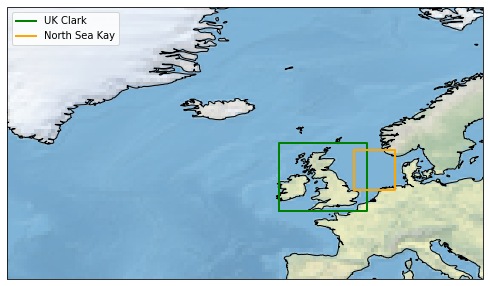

In [7]:
# First, we want to visualise th gridboxes which we might want to use
# The UK grid box or the north sea grid box

# Set up the projection
projection = ccrs.PlateCarree(central_longitude=0)

# Plot the differences between the two gridboxes
# Set up the figure
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# # Include the stock image and coastlines
ax.stock_img()
ax.coastlines()

# Extract the lat and lon data for the UK box
lon1_uk, lon2_uk = dic.uk_grid['lon1'], dic.uk_grid['lon2']
lat1_uk, lat2_uk = dic.uk_grid['lat1'], dic.uk_grid['lat2']

# Extract the lat and lon data for the North Sea box
lon1_ns, lon2_ns = dic.north_sea_kay['lon1'], dic.north_sea_kay['lon2']
lat1_ns, lat2_ns = dic.north_sea_kay['lat1'], dic.north_sea_kay['lat2']

# Plot these boxes
ax.plot([lon1_uk, lon2_uk, lon2_uk, lon1_uk, lon1_uk],
        [lat1_uk, lat1_uk, lat2_uk, lat2_uk, lat1_uk],
        color='green', linewidth=2, transform=projection, label="UK Clark")

# Plot these boxes
ax.plot([lon1_ns, lon2_ns, lon2_ns, lon1_ns, lon1_ns],
        [lat1_ns, lat1_ns, lat2_ns, lat2_ns, lat1_ns],
        color='orange', linewidth=2, transform=projection, label="North Sea Kay")

# Zoom in on the region
ax.set_extent([-50, 20, 40, 80], crs=projection)

# Create a legend
ax.legend(loc = 'upper left')

# show the plot
plt.show()

### Choosing time windows ###

We need to define the time period over which we are looking for wind droughts. Here are three we might consider:

* 1 year (12 months Dec-Nov)
* 3 years (36 months Dec-Nov)
* 5 years (60 months Dec-Nov)

In this first example of 1 year, for 1960 there will be 11 total 12 month time series (DJFMAMJJASON):

* 1 will be the truth (from ERA5) - the weather which actually occurred.
* 10 will be from the decadal prediction system (in this case DePreSys with 10 ensemble members).
    * Here we are assuming November initialisation.

### Extracting the data ###

Model data in this example from HadGEM3-GC31-MM.

Obs data in this example from ERA5.

In [ ]:
# Set up the parameters for extraction
model_var = "sfcWind"
obs_var = "si10"
test_model = "HadGEM3-GC31-MM"

In [ ]:
# Load the observations data as an iris cube
obs = iris.load_cube(dic.obs_path)

obs

In [ ]:
# Load one example of the model data as an iris cube
init_year = 1960
realisation = 1